In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools


In [4]:
def load_cv_analytics_util_see_stats(filesuffix):
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    return cv_analytics_util

def plot_hist_side_by_side_for_class(df, label, xaxis, normalize = True, title=''):
    # Compute histogram
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    num_bins = 20
    positive_df = df[df[label] == 1]
    bin_edges = np.linspace(0, 1, num_bins + 1)
    hist_positive, bin_edges = np.histogram(positive_df[xaxis], bins=bin_edges)

    negative_df = df[df[label] == 0]
    hist_negative, bin_edges = np.histogram(negative_df[xaxis], bins=bin_edges)
    if normalize:
        hist_positive = hist_positive / sum(hist_positive)
        hist_negative = hist_negative / sum(hist_negative)
    ax.hist([bin_edges[:-1], bin_edges[:-1]], bin_edges, weights=[hist_positive, hist_negative], label=['positive', 'negative'])
    ax.legend(title=label)
    ax.set_ylabel('Class percentage')
    ax.set_xlabel(xaxis)
    plt.title(title)
    plt.show()

def get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years'):
    id_and_confidence = []
    for analytics_util in cv_analytics_util.analytics_utils:
        X_test = analytics_util.data_util.test_df
        X_test_mismatch = X_test.copy()
        y_pred, y_prob = analytics_util.get_predictions() 
        X_test_mismatch[f'{label}_pred'] = y_pred
        X_test_mismatch[f'{label}_prob'] = y_prob
        id_and_confidence.append(X_test_mismatch)
    full_dataset = pd.concat(id_and_confidence)
    return full_dataset



Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999674 | 0.000140681 | 0.999468 | 0.999911 |
| recall__class_0    | 0.996763 | 0.000972833 | 0.994682 | 0.998491 |
| f1-score__class_0  | 0.998216 | 0.000497615 | 0.997157 | 0.999156 |
| precision__class_1 | 0.1264   | 0.0586213   | 0.0625   | 0.26087  |
| recall__class_1    | 0.57037  | 0.186152    | 0.333333 | 0.875    |
| f1-score__class_1  | 0.204343 | 0.0861513   | 0.109091 | 0.387097 |
| accuracy           | 0.996441 | 0.000991351 | 0.994332 | 0.998315 |
| auc                | 0.944442 | 0.0359329   | 0.894522 | 0.997687 |
+--------------------+----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


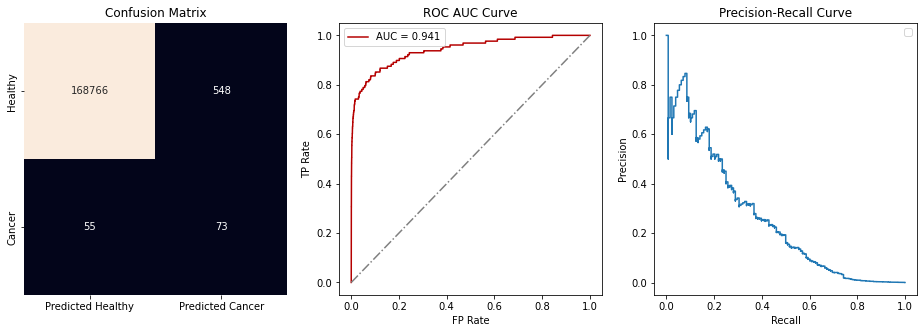

In [39]:
single_cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [9]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
processed_data = convert_numeric_to_float16(processed_data)
label = f'cancer_in_next_1_years'
filesuffix = f'experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials'
experiment_data_helper: ExperimentDataHelper = ExperimentDataHelperScreenedFirst5(processed_data, label, ['cancer_'], train_size = 15000)



Cross-Validation measures:
+--------------------+-----------+-------------+----------+----------+
|                    |      mean |         std |      min |      max |
|--------------------+-----------+-------------+----------+----------|
| precision__class_0 | 0.999556  | 0.000247778 | 0.998928 | 0.999823 |
| recall__class_0    | 0.996491  | 0.000954189 | 0.994962 | 0.998228 |
| f1-score__class_0  | 0.998021  | 0.000482328 | 0.99721  | 0.998899 |
| precision__class_1 | 0.0896236 | 0.0584279   | 0        | 0.189189 |
| recall__class_1    | 0.411636  | 0.215579    | 0        | 0.777778 |
| f1-score__class_1  | 0.143185  | 0.0879177   | 0        | 0.304348 |
| accuracy           | 0.996051  | 0.000961003 | 0.994437 | 0.997802 |
| auc                | 0.825331  | 0.095823    | 0.654408 | 0.97846  |
+--------------------+-----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


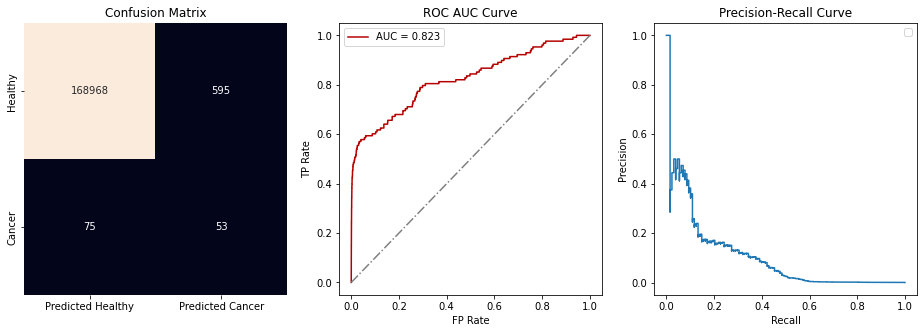

In [10]:
cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [45]:
cols = single_cv_analytics_util.analytics_utils[0].data_util.test_df.columns
full_dataset_single_original = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')[cols]
full_dataset = experiment_data_helper.source_df[cols]
full_dataset = full_dataset[~full_dataset['index'].isin(full_dataset_single_original['index'])]
len(full_dataset)
full_dataset = pd.concat([full_dataset, full_dataset_single_original])

In [48]:
# make sure that the original records stay the same and we just add new ones 249 new ones to be exact
# Add those records to the test datasets of the single label dataset and test its validity
for analytics_util in single_cv_analytics_util.analytics_utils:
    idx = analytics_util.data_util.test_df['plco_id'].to_list()
    # print(analytics_util.data_util.test_df.shape)
    # print((full_dataset[full_dataset['plco_id'].isin(idx)].shape))
    analytics_util.data_util.test_df = full_dataset[full_dataset['plco_id'].isin(idx)]
    analytics_util.data_util.test_df = analytics_util.data_util.imputer.imputer_transform(analytics_util.data_util.test_df)




Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999563 | 9.67292e-05 | 0.999381 | 0.999734 |
| recall__class_0    | 0.999033 | 0.00033271  | 0.998318 | 0.999468 |
| f1-score__class_0  | 0.999298 | 0.000167687 | 0.998937 | 0.999513 |
| precision__class_1 | 0.257703 | 0.0896731   | 0.117647 | 0.416667 |
| recall__class_1    | 0.419444 | 0.132928    | 0.222222 | 0.666667 |
| f1-score__class_1  | 0.313888 | 0.100168    | 0.16     | 0.5      |
| accuracy           | 0.998597 | 0.000334823 | 0.997877 | 0.999027 |
| auc                | 0.944386 | 0.0359415   | 0.894482 | 0.997647 |
+--------------------+----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


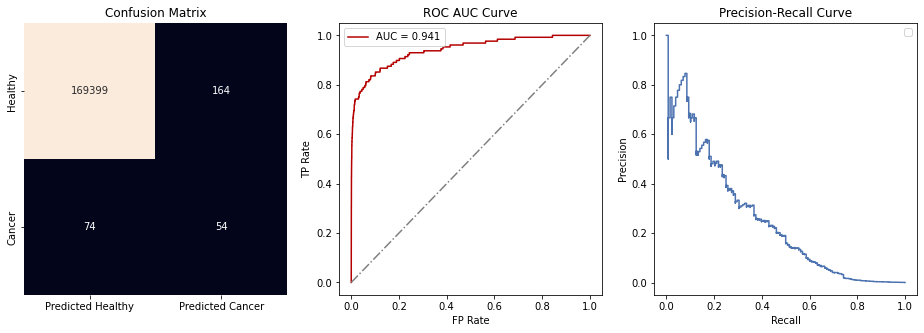

In [55]:
single_cv_analytics_util.update_thresholds(0.5)
single_cv_analytics_util.get_cv_report();
single_cv_analytics_util.display_graph()

In [51]:
full_dataset_single_new = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

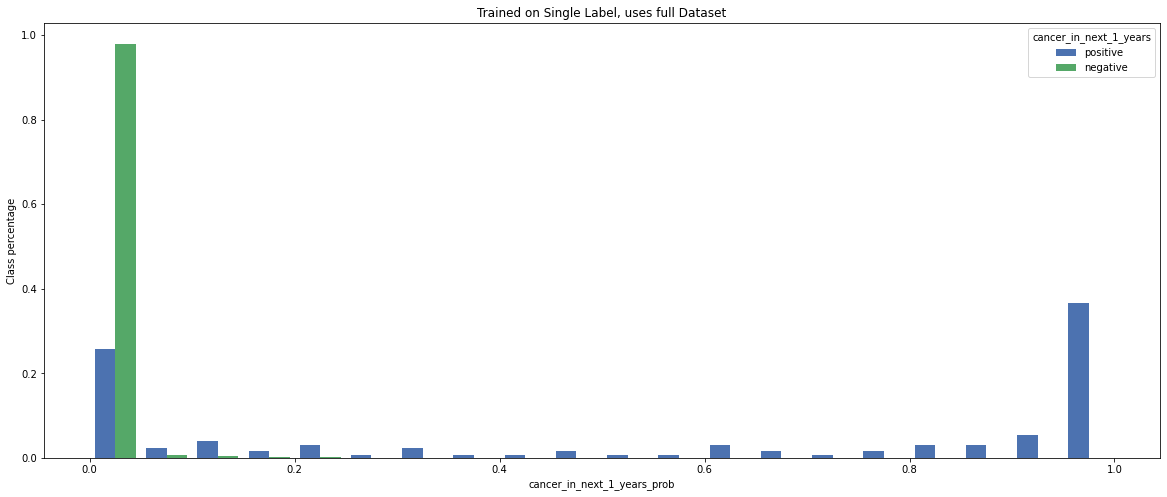

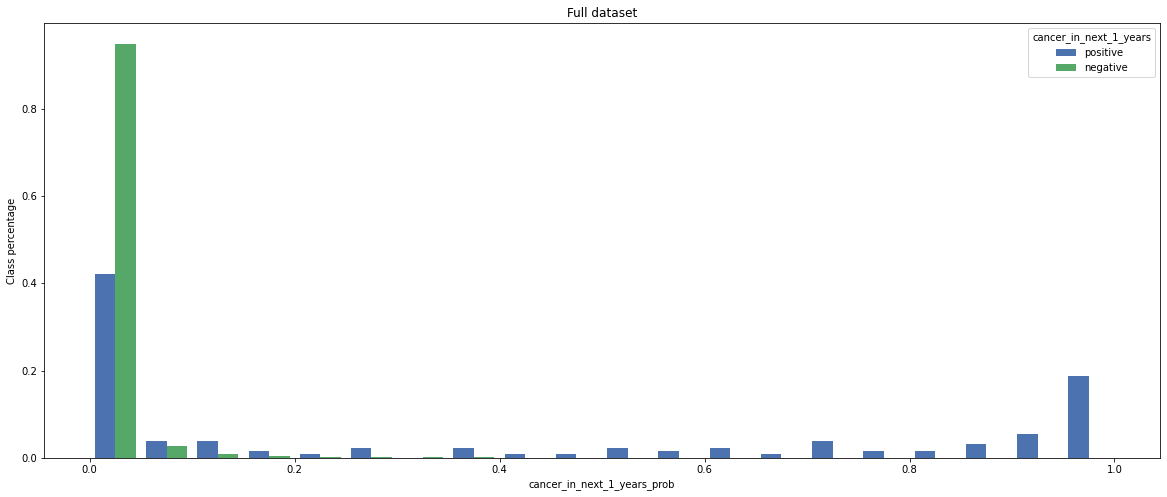

In [54]:

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

# full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
# plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
# full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
# plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')